In [13]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
df = pd.read_csv("filtered_df.csv")

In [3]:
df

,ZipCode,StartTime(UTC)_Traffic,EndTime(UTC)_Traffic,Type_Traffic,Severity_Traffic,Type_Weather,Severity_Weather
0,86005.0,2017-07-28 19:37:54,2017-07-28 20:07:16,Accident,3,Rain,Light
1,86301.0,2017-07-28 22:55:00,2017-07-28 23:53:52,Congestion,2,Rain,Light
2,86005.0,2017-07-28 22:58:00,2017-07-28 23:49:52,Congestion,1,Rain,Light
3,85706.0,2017-07-28 23:23:31,2017-07-28 23:53:18,Accident,2,Rain,Heavy
4,85128.0,2017-07-29 11:33:00,2017-07-29 12:13:42,Congestion,2,Cold,Severe
...,...,...,...,...,...,...,...
3113,86005.0,2020-12-28 23:52:00,2020-12-29 00:37:27,Congestion,2,Snow,Moderate
3114,86005.0,2020-12-29 00:13:00,2020-12-29 00:53:41,Congestion,2,Snow,Moderate
3115,86005.0,2020-12-29 01:45:00,2020-12-29 02:28:29,Congestion,1,Snow,Moderate
3116,86005.0,2020-12-29 01:46:00,2020-12-29 02:28:29,Congestion,1,Snow,Moderate


In [4]:
df['StartTime(UTC)_Traffic'] = pd.to_datetime(df['StartTime(UTC)_Traffic'])
df['EndTime(UTC)_Traffic'] = pd.to_datetime(df['EndTime(UTC)_Traffic'])
df['Duration'] = (df['EndTime(UTC)_Traffic'] - df['StartTime(UTC)_Traffic']).dt.total_seconds() / 60  # Duration in minutes

df_resampled = df.resample('H', on='StartTime(UTC)_Traffic').agg({
    'Severity_Traffic': 'mean',
    'ZipCode': 'first',
    'Type_Traffic': 'first',
    'Type_Weather': 'first',
    'Severity_Weather': 'first',
    'Duration': 'mean'
}).fillna(method='ffill')

# Create input features
df_resampled['hour'] = df_resampled.index.hour
df_resampled['day_of_week'] = df_resampled.index.dayofweek
df_resampled['month'] = df_resampled.index.month
df_resampled['year'] = df_resampled.index.year

# Create lagged features
lag_steps = [1, 2, 3, 6, 12, 24] 
for lag in lag_steps:
    df_resampled[f'lag_{lag}'] = df_resampled['Severity_Traffic'].shift(lag)

# Create moving average features
window_sizes = [3, 6, 12, 24]
for window in window_sizes:
    df_resampled[f'ma_{window}'] = df_resampled['Severity_Traffic'].rolling(window=window).mean()

# One-hot encode categorical features
df_resampled = pd.get_dummies(df_resampled, columns=['Type_Traffic', 'Type_Weather', 'Severity_Weather'])

# Perform label encoding for 'ZipCode'
df_resampled['ZipCode'] = df_resampled['ZipCode'].astype('category').cat.codes

# Drop rows with missing values
df_resampled.dropna(inplace=True)

/var/folders/06/2kgvw4c965v4sfv4w1ythkgc0000gn/T/ipykernel_79621/3947285619.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled = df.resample('H', on='StartTime(UTC)_Traffic').agg({


In [5]:
df_resampled

,Severity_Traffic,ZipCode,Duration,hour,day_of_week,month,year,lag_1,lag_2,lag_3,...,Type_Traffic_Lane-Blocked,Type_Weather_Cold,Type_Weather_Fog,Type_Weather_Rain,Type_Weather_Snow,Type_Weather_Storm,Severity_Weather_Heavy,Severity_Weather_Light,Severity_Weather_Moderate,Severity_Weather_Severe
StartTime(UTC)_Traffic,,,,,,,,,,,,,,,,,,,,,
2017-07-29 19:00:00,1.0,3,41.983333,19,5,7,2017,1.0,1.0,1.0,...,False,True,False,False,False,False,False,False,False,True
2017-07-29 20:00:00,1.0,3,41.983333,20,5,7,2017,1.0,1.0,1.0,...,False,True,False,False,False,False,False,False,False,True
2017-07-29 21:00:00,1.0,3,41.983333,21,5,7,2017,1.0,1.0,1.0,...,False,True,False,False,False,False,False,False,False,True
2017-07-29 22:00:00,1.0,3,41.983333,22,5,7,2017,1.0,1.0,1.0,...,False,True,False,False,False,False,False,False,False,True
2017-07-29 23:00:00,1.0,3,41.983333,23,5,7,2017,1.0,1.0,1.0,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28 21:00:00,0.0,12,43.741667,21,0,12,2020,0.0,0.0,0.0,...,False,False,True,False,False,False,False,False,False,True
2020-12-28 22:00:00,0.0,12,43.741667,22,0,12,2020,0.0,0.0,0.0,...,False,False,True,False,False,False,False,False,False,True
2020-12-28 23:00:00,2.0,19,45.450000,23,0,12,2020,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False


In [6]:
features = df_resampled.drop(columns=['Severity_Traffic'])
target = df_resampled['Severity_Traffic']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)

In [7]:
train_size = int(len(scaled_features_df) * 0.7)
val_size = int(len(scaled_features_df) * 0.2)
train_features = scaled_features_df[:train_size]
train_target = target[:train_size]
val_features = scaled_features_df[train_size:train_size+val_size]
val_target = target[train_size:train_size+val_size]
test_features = scaled_features_df[train_size+val_size:]
test_target = target[train_size+val_size:]

sequence_length = 24
train_sequences = []
train_labels = []
for i in range(sequence_length, len(train_features)):
    train_sequences.append(train_features.iloc[i-sequence_length:i].values)
    train_labels.append(train_target.iloc[i])

val_sequences = []
val_labels = []
for i in range(sequence_length, len(val_features)):
    val_sequences.append(val_features.iloc[i-sequence_length:i].values)
    val_labels.append(val_target.iloc[i])

test_sequences = []
test_labels = []
for i in range(sequence_length, len(test_features)):
    test_sequences.append(test_features.iloc[i-sequence_length:i].values)
    test_labels.append(test_target.iloc[i])

train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sequences, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels))

2024-04-12 14:41:49.534865: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-12 14:41:49.534920: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-12 14:41:49.534928: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-12 14:41:49.534945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-12 14:41:49.534957: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
def build_model(input_shape, num_heads, d_model, dff, dropout_rate):
    inputs = Input(shape=input_shape)
    x = inputs

    for _ in range(2):  # Two-layer Transformer block
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attention_output = Dropout(dropout_rate)(attention_output)
        x = LayerNormalization(epsilon=1e-6)(x + attention_output)

        ffn_output = Dense(dff, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model hyperparameters
num_heads = 8
d_model = train_features.shape[1]
dff = 256
dropout_rate = 0.25
input_shape = (None, d_model)

model = build_model(input_shape, num_heads, d_model, dff, dropout_rate)
model.compile(optimizer='adam', loss='mse')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)

# Train the model
epochs = 50
batch_size = 32

history = model.fit(train_dataset.batch(batch_size), epochs=epochs, validation_data=val_dataset.batch(batch_size), callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_features, test_labels = next(iter(test_dataset.batch(len(test_dataset))))
predictions = model.predict(test_features).flatten()

Epoch 1/50


2024-04-12 14:41:54.903534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


655/655 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - loss: 0.6691 - val_loss: 0.4725 - learning_rate: 0.0010
Epoch 2/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - loss: 0.3417 - val_loss: 0.0965 - learning_rate: 0.0010
Epoch 3/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - loss: 0.2811 - val_loss: 0.1411 - learning_rate: 0.0010
Epoch 4/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - loss: 0.2242 - val_loss: 0.0921 - learning_rate: 0.0010
Epoch 5/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - loss: 0.1889 - val_loss: 0.1455 - learning_rate: 0.0010
Epoch 6/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - loss: 0.2100 - val_loss: 0.0861 - learning_rate: 0.0010
Epoch 7/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - loss: 0.1891 - val_loss: 0.0727 - learning_rate: 0.0010
Epoch 8/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - loss: 0.1565 - val_loss: 0.1032 - learning_rate: 0.0010
Epoch 9/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - loss: 0.1794 - val_loss: 0.0665 - learning_rate: 0.0010
Epo

MAE: 0.1851968835278907
RMSE: 0.2918363496993558
R^2: 0.8887419581308429


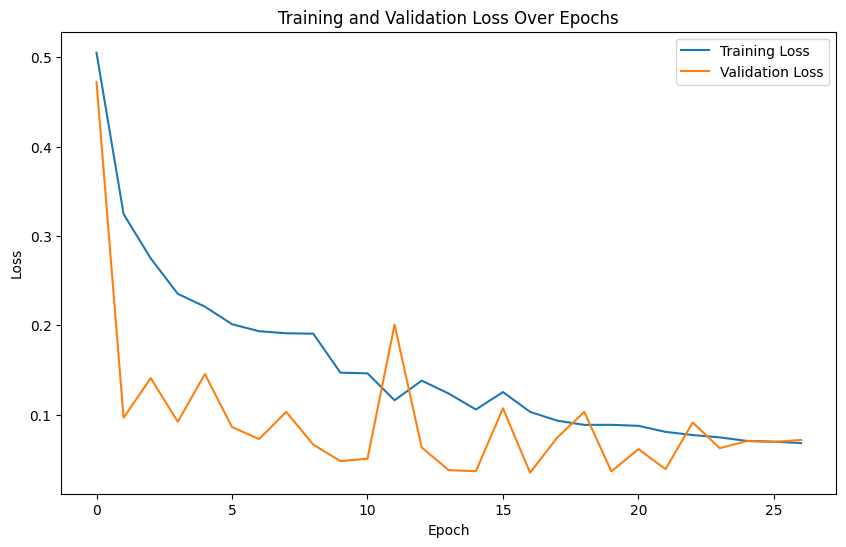

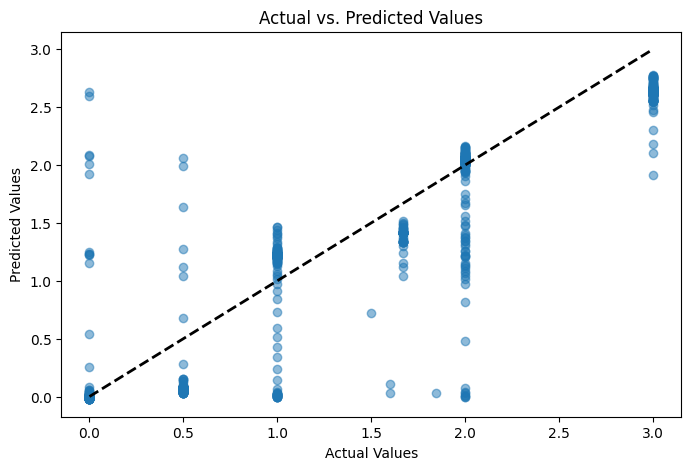

   Actual  Predicted
0     2.0   2.065557
1     2.0   2.066081
2     2.0   2.066445
3     2.0   2.066674
4     2.0   2.066785


In [9]:
mae = mean_absolute_error(test_labels, predictions)
rmse = np.sqrt(mean_squared_error(test_labels, predictions))
r2 = r2_score(test_labels, predictions)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Actual vs Predicted Scatter Plot
plt.figure(figsize=(8, 5))
plt.scatter(test_labels.numpy(), predictions, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([test_labels.numpy().min(), test_labels.numpy().max()], [test_labels.numpy().min(), test_labels.numpy().max()], 'k--', lw=2)
plt.show()

actual_values = test_labels.numpy().flatten()
predicted_values = predictions.flatten()
df_results = pd.DataFrame({'Actual': actual_values, 'Predicted': predicted_values})
print(df_results.head())

In [19]:
predicted_labels = np.round(predictions).astype(int)
actual_labels = np.round(test_labels.numpy()).astype(int)

accuracy = accuracy_score(actual_labels, predicted_labels)

f1 = f1_score(actual_labels, predicted_labels, average='weighted')

precision = precision_score(actual_labels, predicted_labels, average='weighted')

recall = recall_score(actual_labels, predicted_labels, average='weighted')

report = classification_report(actual_labels, predicted_labels)

cm = confusion_matrix(actual_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report")
print(classification_report(actual_labels, predicted_labels))
print("\nConfusion Matrix:")
print(cm)

Accuracy: 0.9472
F1 Score: 0.9462
Precision: 0.9486
Recall: 0.9472

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1049
           1       0.92      0.98      0.95      1171
           2       0.97      0.81      0.88       540
           3       0.99      0.97      0.98       213

    accuracy                           0.95      2973
   macro avg       0.96      0.93      0.95      2973
weighted avg       0.95      0.95      0.95      2973


Confusion Matrix:
[[1030   10    7    2]
 [  29 1142    0    0]
 [  11   92  437    0]
 [   0    0    6  207]]


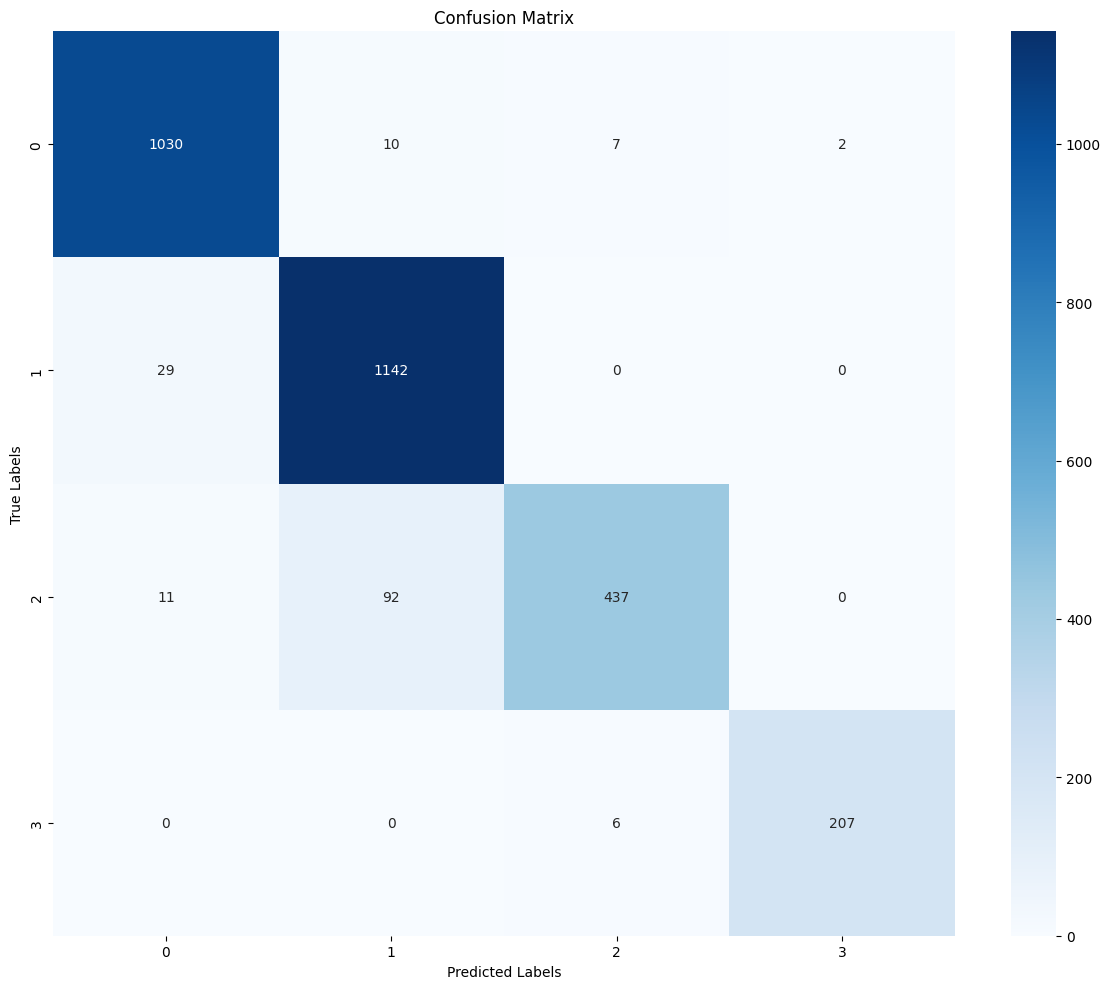

In [20]:
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(actual_labels, predicted_labels), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()